# TfL Cycling Data Analysis (2021–2023)

This notebook presents an exploratory analysis of Transport for London (TfL) cycle hire data from 2021 to 2023.
Our goal is to extract usage insights and prototype a simple machine learning model to support a client considering entry into the short-term bike rental market. 


In [1]:
# We begin by importing essential Python libraries for data loading, analysis, and visualization.
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

## preprocessing the data

A total of 142 CSV files were scraped from the [TfL Cycling Dataset](https://cycling.data.tfl.gov.uk/), covering usage stats from 2021 to 2023.  

The data comes in two schema formats (old and new), and we load them separately to ensure compatibility.  
In this step, we load data from the **old schema** files and concatenate them into a single DataFrame.

In [2]:
# Get full paths for all CSV files in the old schema folder and load them into a single dataframe
folder_path1 = "./cycling_data_old_schema"
cyclic_data_files = [os.path.join(folder_path1, i) for i in os.listdir(folder_path1)]
print(len(cyclic_data_files))
df_list = []
for file in cyclic_data_files:
    df1 = pd.read_csv(file, dtype={
    "StartStation Id": str,
    "EndStation Id": str})
    df_list.append(df1)
    print(f"Loaded: {file} ({len(df1)} rows)")

df1 = pd.concat(df_list, ignore_index=True)
print(f"Concatenated {len(df1)} rows from {len(df_list)} files")

89
Loaded: ./cycling_data_old_schema\246JourneyDataExtract30Dec2020-05Jan2021.csv (93002 rows)
Loaded: ./cycling_data_old_schema\247JourneyDataExtract06Jan2021-12Jan2021.csv (92212 rows)
Loaded: ./cycling_data_old_schema\248JourneyDataExtract13Jan2021-19Jan2021.csv (91203 rows)
Loaded: ./cycling_data_old_schema\249JourneyDataExtract20Jan2021-26Jan2021.csv (95317 rows)
Loaded: ./cycling_data_old_schema\250JourneyDataExtract27Jan2021-02Feb2021.csv (91658 rows)
Loaded: ./cycling_data_old_schema\251JourneyDataExtract03Feb2021-09Feb2021.csv (82029 rows)
Loaded: ./cycling_data_old_schema\252JourneyDataExtract10Feb2021-16Feb2021.csv (89405 rows)
Loaded: ./cycling_data_old_schema\253JourneyDataExtract17Feb2021-23Feb2021.csv (153873 rows)
Loaded: ./cycling_data_old_schema\254JourneyDataExtract24Feb2021-02Mar2021.csv (189092 rows)
Loaded: ./cycling_data_old_schema\255JourneyDataExtract03Mar2021-09Mar2021.csv (150317 rows)
Loaded: ./cycling_data_old_schema\256JourneyDataExtract10Mar2021-16Mar2021

Cleaning and Normalizing the Old Schema

To ensure compatibility with the newer schema and avoid schema-specific biases, we:

- Drop unreliable station ID columns (`StartStation Id`, `EndStation Id`) which change schema-wise.
- Normalize station names for consistency across files.
- Rename columns to match the new schema format.

We will rely on **station names** for grouping, as they are more consistent across schema versions.

In [3]:
def normalize_name(name):
    name = str(name).strip().lower()
    name = name.replace(',', '')              # remove commas
    name = re.sub(r'\s+', ' ', name)          # collapse multiple spaces into one
    return name

df1['StartStation Name'] = df1['StartStation Name'].apply(normalize_name)
df1['EndStation Name'] = df1['EndStation Name'].apply(normalize_name)

df1 = df1.rename(columns={
    'EndStation Name': 'End station',
    'StartStation Name': 'Start station',
    'Bike Id': 'Bike number'
})
df1 = df1.drop(columns=['EndStation Id', 'StartStation Id'])
df1.head()

,Rental Id,Duration,Bike number,End Date,End station,Start Date,Start station
0,104820582,1620,22,03/01/2021 15:14,brunswick square bloomsbury,03/01/2021 14:47,salmon lane limehouse
1,104816169,1740,10755,03/01/2021 13:26,salmon lane limehouse,03/01/2021 12:57,new fetter lane holborn
2,104757113,1620,18908,30/12/2020 15:00,warren street station euston,30/12/2020 14:33,houndsditch aldgate
3,104749458,780,18499,30/12/2020 09:21,ram street wandsworth,30/12/2020 09:08,simpson street clapham junction
4,104788389,5400,15668,01/01/2021 16:29,crabtree lane fulham,01/01/2021 14:59,crabtree lane fulham


Deduplication and Null Check

We check for:
- Duplicate rental records (`Rental Id`)
- Missing values in any fields

In [4]:
print("Number of duplicate Rental Ids:", df1['Rental Id'].duplicated().sum())
df1.isnull().sum()

Number of duplicate Rental Ids: 0


Rental Id        0
Duration         0
Bike number      0
End Date         0
End station      0
Start Date       0
Start station    0
dtype: int64

Loading and Cleaning New Schema Files

Now we load the second batch of data, which follows a **newer schema**, and apply equivalent cleaning steps:

- Normalize column names
- Standardize duration format (milliseconds → seconds)
- Drop unnecessary columns
- Normalize station names for consistency

In [5]:
# Get full paths for all CSV files in the new schema folder and load them into a single dataframe
folder_path2 = "./cycling_data_new_schema"
cyclic_data_files = [os.path.join(folder_path2, i) for i in os.listdir(folder_path2)]
print(len(cyclic_data_files))
df_list = []
for file in cyclic_data_files:
    df2 = pd.read_csv(file, dtype={
    "Start station number": str,
    "End station number": str})
    df_list.append(df2)
    print(f"Loaded: {file} ({len(df2)} rows)")

if df_list:
    df2 = pd.concat(df_list, ignore_index=True)
    print(f"Concatenated {len(df2)} rows from {len(df_list)} files")
else:
    print("No files loaded")

53
Loaded: ./cycling_data_new_schema\335JourneyDataExtract12Sep2022-18Sep2022.csv (178494 rows)
Loaded: ./cycling_data_new_schema\336JourneyDataExtract19Sep2022-25Sep2022.csv (186434 rows)
Loaded: ./cycling_data_new_schema\337JourneyDataExtract26Sep2022-02Oct2022.csv (173300 rows)
Loaded: ./cycling_data_new_schema\338JourneyDataExtract03Oct2022-09Oct2022.csv (204517 rows)
Loaded: ./cycling_data_new_schema\339JourneyDataExtract10Oct2022-16Oct2022.csv (194928 rows)
Loaded: ./cycling_data_new_schema\340JourneyDataExtract17Oct2022-23Oct2022.csv (184097 rows)
Loaded: ./cycling_data_new_schema\341JourneyDataExtract24Oct2022-30Oct2022.csv (202605 rows)
Loaded: ./cycling_data_new_schema\342JourneyDataExtract31Oct2022-06Nov2022.csv (156440 rows)
Loaded: ./cycling_data_new_schema\343JourneyDataExtract07Nov2022-13Nov2022.csv (197950 rows)
Loaded: ./cycling_data_new_schema\344JourneyDataExtract14Nov2022-20Nov2022.csv (157910 rows)
Loaded: ./cycling_data_new_schema\345JourneyDataExtract21Nov2022-27

Final Cleaning for New Schema Data

To ensure consistency with the old schema (`df1`), we:

- Convert **duration** from milliseconds to seconds and rename the column.
- Drop station ID number columns (since we use normalized names).
- Normalize station names (lowercase, trimmed, no commas).
- Rename date and rental ID columns to match the old schema.

This prepares the new schema data (`df2`) for merging.

In [6]:
if 'Total duration' in df2.columns:
    df2 = df2.drop(columns=['Total duration'])
if 'Total duration (ms)' in df2.columns:
    df2 = df2.rename(columns={'Total duration (ms)': 'Duration'})
    df2['Duration'] = (df2['Duration'] / 1000).astype(int)

df2.drop(columns=['Start station number', 'End station number'], inplace=True)

df2['Start station'] = df2['Start station'].apply(normalize_name)
df2['End station'] = df2['End station'].apply(normalize_name)

# Rename columns for df2
df2 = df2.rename(columns={
    'Number': 'Rental Id',
    'Start date': 'Start Date',
    'End date': 'End Date'
})
df2.head()

,Rental Id,Start Date,Start station,End Date,End station,Bike number,Bike model,Duration
0,125230172,2022-09-18 23:59,albert embankment vauxhall,2022-09-19 02:11,danvers street west chelsea,54170,CLASSIC,7934
1,125230173,2022-09-18 23:59,frith street soho,2022-09-19 00:11,westminster university marylebone,50087,CLASSIC,736
2,125230174,2022-09-18 23:59,bramham gardens earl's court,2022-09-19 00:14,felsham road putney,54561,CLASSIC,929
3,125230175,2022-09-18 23:59,strata elephant & castle,2022-09-19 00:23,canada water station rotherhithe,54324,CLASSIC,1411
4,125230176,2022-09-18 23:59,strata elephant & castle,2022-09-19 00:23,canada water station rotherhithe,22065,CLASSIC,1400


Duplicate Check & Missing Values

Before merging both datasets, we inspect `df2` for duplicate Rental IDs and null values.

In [7]:
print("Number of duplicate Rental Ids:", df2['Rental Id'].duplicated().sum())
df2.isnull().sum()

Number of duplicate Rental Ids: 0


Rental Id        0
Start Date       0
Start station    0
End Date         0
End station      0
Bike number      0
Bike model       0
Duration         0
dtype: int64

Combine Old & New Schema DataFrames

We now concatenate the cleaned `df1` and `df2` DataFrames into a single unified dataset, `df`, ready for exploratory data analysis.

In [8]:
df = pd.concat([df1, df2], ignore_index=True)
len(df)
df.head()

,Rental Id,Duration,Bike number,End Date,End station,Start Date,Start station,Bike model
0,104820582,1620,22,03/01/2021 15:14,brunswick square bloomsbury,03/01/2021 14:47,salmon lane limehouse,NaN
1,104816169,1740,10755,03/01/2021 13:26,salmon lane limehouse,03/01/2021 12:57,new fetter lane holborn,NaN
2,104757113,1620,18908,30/12/2020 15:00,warren street station euston,30/12/2020 14:33,houndsditch aldgate,NaN
3,104749458,780,18499,30/12/2020 09:21,ram street wandsworth,30/12/2020 09:08,simpson street clapham junction,NaN
4,104788389,5400,15668,01/01/2021 16:29,crabtree lane fulham,01/01/2021 14:59,crabtree lane fulham,NaN


## Exploratory Data Analysis

### Short Trips & False Starts

As a first step in our exploratory analysis, we examine **very short trips** — those under 120 seconds.  
These can be indicative of:

- **False starts** (user unlocks bike, but doesn't proceed)
- **Usability issues** (faulty bike or docking problems)
- **Customer dissatisfaction** (confusing station layout or UX problems)

We also identify a subset where the **start and end stations are the same**, which may reflect abandonment behavior or unclear instructions.

These trips are excluded from further analysis to ensure the quality and integrity of insights.

In [9]:
# Total number of trips
total_trips = len(df)

# Trips with duration <= 120 seconds
short_trips = df[df['Duration'] <= 120]
num_short_trips = len(short_trips)
pct_short_trips = (num_short_trips / total_trips) * 100

# Short trips where start == end station
false_start_trips = short_trips[short_trips['Start station'] == short_trips['End station']]
num_false_start_trips = len(false_start_trips)
pct_false_start_trips = (num_false_start_trips / total_trips) * 100

# Output
print(f"Total trips: {total_trips}")
print(f"Trips ≤ 120 sec: {num_short_trips} ({pct_short_trips:.2f}%)")
print(f"Trips ≤ 120 sec and same start/end station: {num_false_start_trips} ({pct_false_start_trips:.2f}%)")

Total trips: 30786752
Trips ≤ 120 sec: 499895 (1.62%)
Trips ≤ 120 sec and same start/end station: 185511 (0.60%)


Interpretation & Recommendation

- Only **1.62%** of total trips were under 2 minutes.
- Of these, a smaller subset (**0.60%**) had identical start and end stations — likely false starts or cancellations.

While rare, these trips are critical signals of **user friction** and should be monitored:
- Consider **removing unlock fees** or adding a **grace period** for trips under 2 minutes.
- Analyze station-level patterns to identify **problematic stations or bikes**.
- These low rates also indicate **minimal misuse**, which is a positive signal for operational trust.

---

We will now **exclude these trips** to maintain the quality of the core usage analysis.

In [10]:
# Filter out trips with Duration ≤ 120 seconds
df = df[df['Duration'] > 120].copy()

# Confirm removal
print(f"Remaining trips after filtering: {len(df)}")

Remaining trips after filtering: 30286857


### Outlier & Long Duration Trip Analysis

While most cycle hires are short and practical, a subset of trips has **abnormally high durations**.  
These may indicate:

- Forgotten or failed docking
- Software or return system errors
- Bike theft or improper use

We use **IQR (Interquartile Range)** to identify statistical outliers and highlight extremely long trips (> 12 hours) which violate expected behavior for a short-term rental service.


In [11]:
# Calculate IQR-based upper bound
df['Duration_min'] = df['Duration'] / 60
Q1 = df['Duration_min'].quantile(0.25)
Q3 = df['Duration_min'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Count high-duration outliers
high_outliers = df[df['Duration_min'] > upper_bound]
num_high_outliers = len(high_outliers)
total_trips = len(df)
pct_high_outliers = (num_high_outliers / total_trips) * 100

print(f"Upper Bound: {upper_bound:.2f} min")
print(f"High-duration outliers: {num_high_outliers}")
print(f"Percentage of total: {pct_high_outliers:.2f}%")

Upper Bound: 41.95 min
High-duration outliers: 1985471
Percentage of total: 6.56%


Observations

- Approximately **6.5%** of trips exceed `42` minutes.
- This represents trips far beyond the normal usage pattern and affects **system availability** for genuine users.

**Business Implication:**  
To ensure fairness and maximize usage, long trips should be disincentivized or monitored through:

- Time-based pricing tiers
- Penalties for misuse
- Real-time tracking of idle/stuck bikes

---

Extremely Long Trips (> 12 hours)

These are very rare but serious from an operational standpoint.
They may indicate:
- Forgotten returns
- Docking station errors
- Stolen or abandoned bikes

In [12]:
num_long_trips = (df['Duration_min'] > 720).sum()
total_trips = len(df)
pct_long_trips = (num_long_trips / total_trips) * 100

print(f"Trips > 12 hours: {num_long_trips} ({pct_long_trips:.2f}%) of total trips")

Trips > 12 hours: 32970 (0.11%) of total trips


### Trip Duration Insights

Now we summarize the core distribution of **trip durations** in minutes, helping us understand typical usage patterns and outliers.

In [13]:
desc_stats = df['Duration_min'].describe()
skew = df['Duration_min'].skew()

print(f"""
Fastest completed trip: {desc_stats['min']:.2f} min
Longest ride — could be sightseeing, accidental non-return, or outlier: {desc_stats['max']:.2f} min
Average trip duration: {desc_stats['mean']:.2f} min
Typical trip: {desc_stats['50%']:.2f} min
""")



Fastest completed trip: 2.02 min
Longest ride — could be sightseeing, accidental non-return, or outlier: 187750.63 min
Average trip duration: 22.93 min
Typical trip: 14.00 min



Quantiles help us understand how trip durations vary across the population — from short inner-city commutes to longer leisure rides.

In [14]:
# Compute quantiles
quantiles = df['Duration_min'].quantile([0.25, 0.5, 0.75, 0.95, 0.99])

# Print each with insight
print(f"25% Quantile: {quantiles[0.25]:.2f} min → 25% of rides are shorter than this — likely short-trip users.")
print(f"50% Quantile (Median): {quantiles[0.50]:.2f} min → Half of all rides are shorter than this.")
print(f"75% Quantile: {quantiles[0.75]:.2f} min → Upper bound of typical trip durations.")
print(f"95% Quantile: {quantiles[0.95]:.2f} min → Longest 5% — often leisure, tourist, or extended use.")

25% Quantile: 8.70 min → 25% of rides are shorter than this — likely short-trip users.
50% Quantile (Median): 14.00 min → Half of all rides are shorter than this.
75% Quantile: 22.00 min → Upper bound of typical trip durations.
95% Quantile: 48.87 min → Longest 5% — often leisure, tourist, or extended use.


### Temporal Usage Trends

We now explore when people ride most frequently — by **hour of day** and **day of week**.

These insights help the business:

- Understand peak demand windows
- Schedule rebalancing and maintenance
- Target marketing or pricing strategies

In [15]:
def parse_date_simple(date_str):
    try:
        # First try: DD/MM/YYYY HH:MM
        return datetime.strptime(date_str, "%d/%m/%Y %H:%M")
    except (ValueError, TypeError):
        try:
            # Fallback: YYYY-MM-DD HH:MM
            return datetime.strptime(date_str, "%Y-%m-%d %H:%M")
        except (ValueError, TypeError):
            return date_str  # return original if both fail

# Apply to your Start Date column
df['Start Date'] = df['Start Date'].apply(parse_date_simple)


# Extract hour of day and weekday name
df['hour'] = df['Start Date'].dt.hour
df['weekday'] = df['Start Date'].dt.day_name()

# Reorder weekdays so they show up properly in heatmap
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)

# Create pivot table: number of trips per (weekday, hour) combination
heatmap_data = df.pivot_table(
    index='weekday',
    columns='hour',
    values='Rental Id',
    aggfunc='count',
    fill_value=0,
    observed=False
)

Ride Starts by Day and Hour

The following heatmap reveals **ride start density** across days and hours — an operationally valuable view into:

- Commuting peaks (weekday mornings/evenings)
- Leisure surges (weekend afternoons)

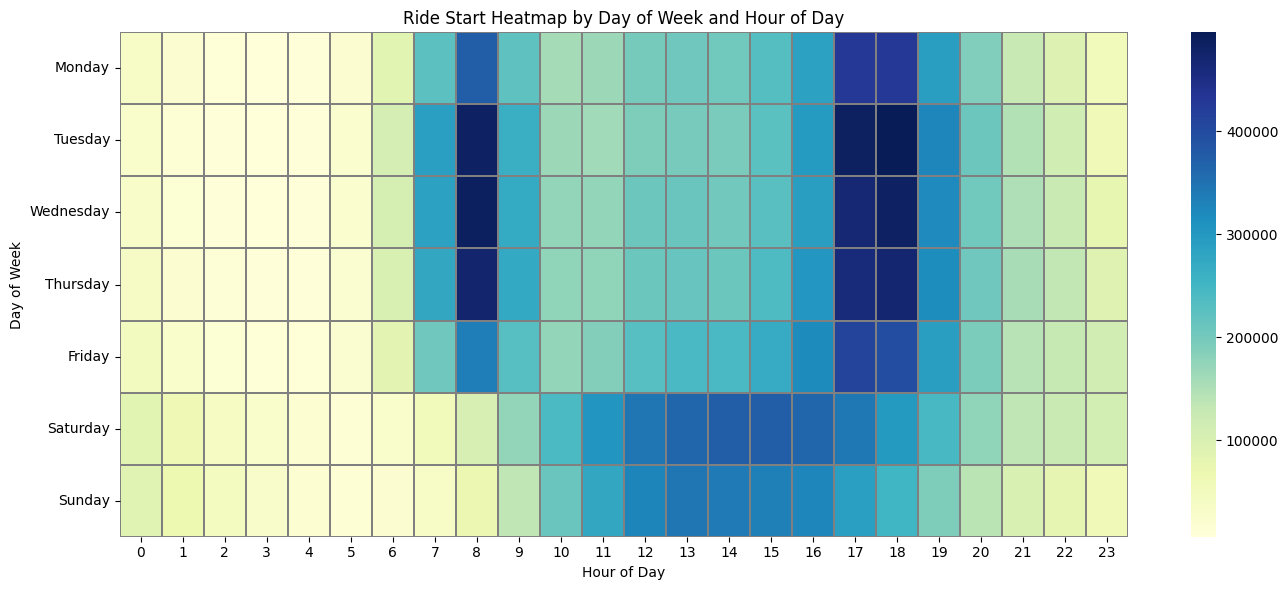

In [16]:
# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.3, linecolor='gray')
plt.title("Ride Start Heatmap by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

Insights from the Heatmap

- **Weekday mornings (7–9am)** and **evenings (5–7pm)** show commuting peaks.
- **Weekend afternoons (10am–6pm)** show high leisure activity.
- Usage patterns differ by user intent — commuting vs. recreation — which may inform:
  - Dynamic pricing models
  - Strategic bike/station placement
  - Operational rebalancing schedules

Why This Matters: Forecasting & Operations
Understanding temporal demand patterns helps the business in several ways:

Demand Forecasting: Historical hourly and daily usage trends can be used to train time-series or regression models to predict future demand — especially useful for high-traffic stations.

Rebalancing Strategy: Knowing peak times helps optimize bike redistribution schedules, ensuring stations are neither empty nor overfull.

Maintenance & Staffing: Predictable demand cycles can guide staff deployment for repairs, returns, or customer support.

Dynamic Pricing: Demand-aware pricing can be introduced to encourage off-peak usage or premium pricing in high-demand periods.

### Station-Level Analysis — Top Start & End Stations

Understanding which stations see the most activity helps with:

- Infrastructure prioritization (expansion, maintenance)
- Local demand targeting
- Operational support and balancing needs

In [17]:
# Top 10 Start Stations
top_start_stations = df['Start station'].value_counts().head(10)
print("Top 10 Start Stations:")
print(top_start_stations)

# Top 10 End Stations
top_end_stations = df['End station'].value_counts().head(10)
print("\nTop 10 End Stations:")
print(top_end_stations)


Top 10 Start Stations:
Start station
hyde park corner hyde park            230998
albert gate hyde park                 139857
waterloo station 3 waterloo           137406
black lion gate kensington gardens    132278
hop exchange the borough              129490
wormwood street liverpool street      128771
wellington arch hyde park             127419
waterloo station 1 waterloo           124565
duke street hill london bridge        123562
westminster pier westminster          119355
Name: count, dtype: int64

Top 10 End Stations:
End station
hyde park corner hyde park            229863
hop exchange the borough              172436
waterloo station 3 waterloo           141405
albert gate hyde park                 139425
black lion gate kensington gardens    132437
brushfield street liverpool street    131594
duke street hill london bridge        130813
wormwood street liverpool street      130287
wellington arch hyde park             127340
westminster pier westminster          124326
Nam

Identifying Station Imbalance — Sources vs Sinks

We now identify **net imbalances** between ride starts and ends at each station.

- **Source-heavy stations** → More departures than arrivals  
  → Bikes may **drain quickly** if not replenished

- **Sink-heavy stations** → More arrivals than departures  
  → Bikes may **pile up**, requiring collection or redistributi

In [18]:
# Count of rides starting from each station
starts = df['Start station'].value_counts().rename('starts')

# Count of rides ending at each station
ends = df['End station'].value_counts().rename('ends')

# Merge both into a single DataFrame
station_flow = pd.concat([starts, ends], axis=1).fillna(0)

# Calculate net flow and ratio
station_flow['net_flow'] = station_flow['ends'] - station_flow['starts']
station_flow['end_start_ratio'] = station_flow['ends'] / station_flow['starts'].replace(0, 1)

In [19]:
top_sinks = station_flow.sort_values('net_flow', ascending=False).head(10)
print("Top 10 Sink Stations (more ends than starts):")
print(top_sinks[['net_flow', 'end_start_ratio']])

top_sources = station_flow.sort_values('net_flow').head(10)
print("Top 10 Source Stations (more starts than ends):")
print(top_sources[['net_flow', 'end_start_ratio']])

Top 10 Sink Stations (more ends than starts):
                                    net_flow  end_start_ratio
hop exchange the borough             42946.0         1.331655
st. james's square st. james's       31064.0         1.348013
queen street 1 bank                  25726.0         1.374960
brushfield street liverpool street   19558.0         1.174569
whitehall place strand               18126.0         1.204594
holborn circus holborn               15764.0         1.257099
soho square soho                     14411.0         1.145648
william iv street strand             10881.0         1.168810
st. bride street holborn             10873.0         1.327609
pall mall east west end               9662.0         1.164038
Top 10 Source Stations (more starts than ends):
                                          net_flow  end_start_ratio
waterloo station 2 waterloo               -23488.0         0.708024
lancaster gate bayswater                  -14233.0         0.729452
cloudesley road ange

Operational Insights

- Stations with high **positive net flow** (sinks) may **overflow with bikes** during peak periods and need regular redistribution.
- Stations with high **negative net flow** (sources) can **run out of bikes**, frustrating customers during high-demand periods.
- These insights can guide:
  - **Strategic station placement**
  - **Bike redistribution planning**
  - **Demand forecasting models** (predict station-level inventory needs)
  - **Incentive programs** to encourage returns to underused stations


What More Could Be Explored from the Data

- **Temporal Trends**: Analyzing usage trends by day, week, or season to uncover growth patterns and seasonality.
- **Model-Level Analysis**: Comparing trip durations and volumes by bike model to inform fleet composition strategy.
- **Route-Level Behavior**: Investigating frequent station pairs and self-loop trips to identify high-traffic corridors or user confusion zones.


## Data Science Use Cases

Here are several data-driven opportunities that align with the TfL cycling data and the client’s operational and strategic goals:

---

### 1. Demand Forecasting (Time Series Modeling)

**Goal**: Predict future demand for bikes at each station by hour/day.

**Value**: Helps proactively manage bike distribution, staffing, and inventory availability.

**Approach**:
- Time-series models (ARIMA) or ML regressors
- Features: date, time, day-of-week, historical usage

---

### 2. Trip Duration Prediction

**Goal**: Estimate how long a user will ride based on start time, station pair, and bike model.

**Value**: Improves customer expectations, supports dynamic pricing, and helps estimate bike availability timelines.

**Approach**:
- Supervised regression (Linear Regression, XGBoost)
- Features: hour, day, start/end stations, bike model

---

### 3. Route & Usage Pattern Clustering

**Goal**: Discover common usage patterns such as commuting, leisure, or anomalous routes.

**Value**: Supports marketing segmentation, route recommendations, and strategic planning.

**Approach**:
- Unsupervised learning (K-Means, DBSCAN)
- Features: start/end stations, duration, time of day

---

### 4. Bike Availability Prediction

**Goal**: Predict when a station is likely to **run out of bikes** or become **completely full**.

**Value**: Enables proactive rebalancing and avoids customer frustration due to unavailability.

**Approach**:
- Classification or regression models
- Features: historical demand trends, time of day, day of week, and station flow patterns

---

### 5. Station Rebalancing Optimization

**Goal**: Recommend how many bikes to move between stations to maintain service levels.

**Value**: Reduces stockouts and overflow, ensuring user satisfaction and operational efficiency.

**Approach**:
- Predict demand at source/sink stations
- Use optimization (e.g., Linear Programming) or Reinforcement Learning to route rebalancing trucks

---

These applications transform historical rental data into predictive, prescriptive, and diagnostic intelligence to support a smarter, scalable, and user-friendly bike rental service.

---


## Forecasting Daily Bike Demand

To demonstrate how data science can support **operational planning and rebalancing**, we prototype a simple **time series model** to forecast **daily bike rentals**.

We use the `darts` library to apply two out-of-the-box forecasting models:

- **Exponential Smoothing** — a baseline method suitable for trend and seasonality
- **ARIMA** — a statistical model for time series with autocorrelation

These models are used *without hyperparameter tuning* or external regressors (like weather, holidays, or station-level splits), and are intended only as a first-pass demonstration.

c:\Users\premd\Documents\Cyclic Analysis\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\premd\Documents\Cyclic Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\premd\Documents\Cyclic Analysis\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


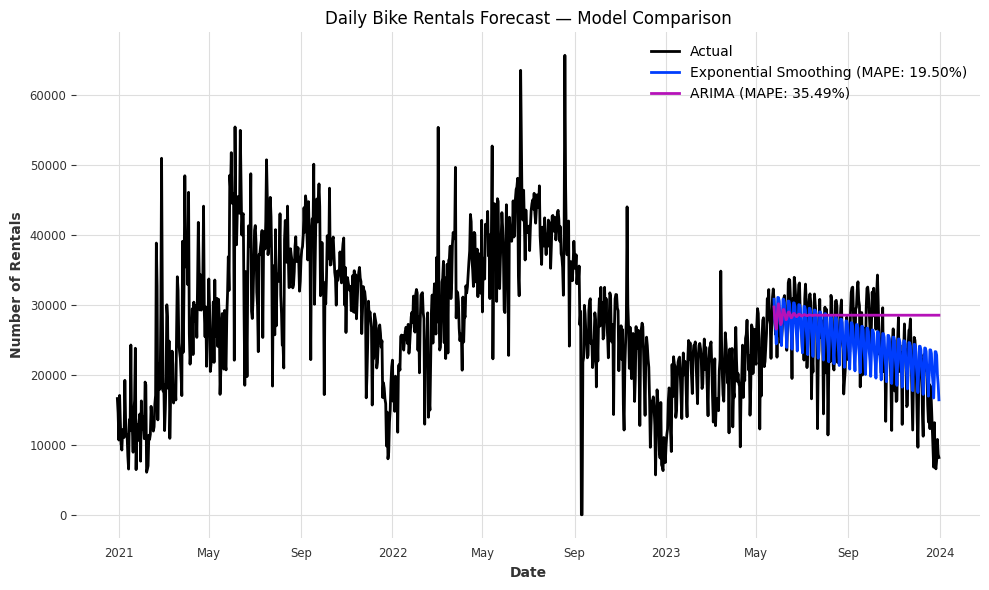

In [20]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA
from darts.metrics import mape

daily_counts = df.groupby(df["Start Date"].dt.date).size().reset_index(name="num_rentals")
daily_counts["Start Date"] = pd.to_datetime(daily_counts["Start Date"])

series = TimeSeries.from_dataframe(daily_counts, time_col="Start Date", value_cols="num_rentals")

train, val = series.split_before(0.8)

models = {
    "Exponential Smoothing": ExponentialSmoothing(),
    "ARIMA": ARIMA()
}

plt.figure(figsize=(10, 6))
series.plot(label="Actual")

for name, model in models.items():
    model.fit(train)
    pred = model.predict(len(val))
    error = mape(val, pred)
    pred.plot(label=f"{name} (MAPE: {error:.2f}%)")

plt.title("Daily Bike Rentals Forecast — Model Comparison")
plt.xlabel("Date")
plt.ylabel("Number of Rentals")
plt.legend()
plt.tight_layout()
plt.show()